Strategy Period: 2003-11-30 00:00:00 to 2025-06-08 00:00:00
Total weeks: 1124


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2004-01-04   2004-01-04
End Period                 2025-06-08   2025-06-08
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       75.0%

Cumulative Return          31.45%       75.2%
CAGR﹪                     0.88%        1.82%

Sharpe                     1.33         4.14
Prob. Sharpe Ratio         99.19%       100.0%
Smart Sharpe               1.05         3.27
Sortino                    1.74         9.06
Smart Sortino              1.37         7.16
Sortino/√2                 1.23         6.41
Smart Sortino/√2           0.97         5.07
Omega                      2.94         2.94

Max Drawdown               -15.38%      -3.61%
Longest DD Days            1422         764
Volatility (ann.)          4.71%        3.06%
R^2                        0.45         0.45
Information Ratio          0.12         0.12
Calmar                  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-03-04,2008-04-20,2009-04-05,764,-3.608025,-3.442829
2,2021-11-21,2022-04-24,2022-12-04,379,-1.589129,-1.576496
3,2010-04-11,2010-05-09,2010-11-07,211,-1.381878,-1.372829
4,2020-01-26,2020-03-01,2020-04-12,78,-1.099621,-0.299574
5,2020-05-17,2020-05-17,2020-05-24,8,-0.950517,-0.608901


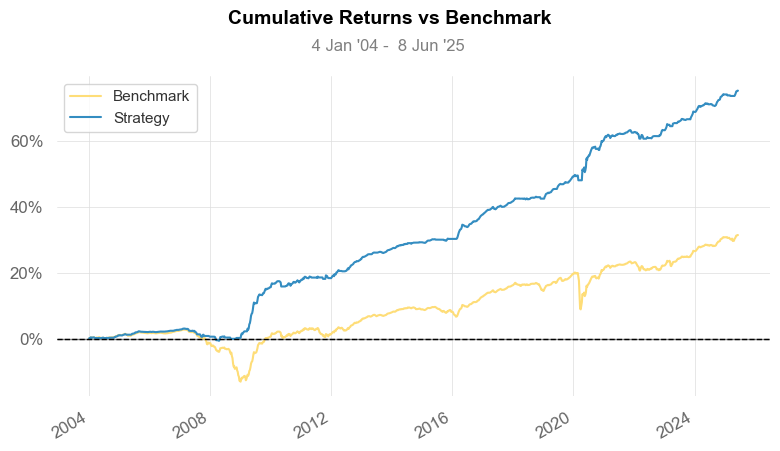

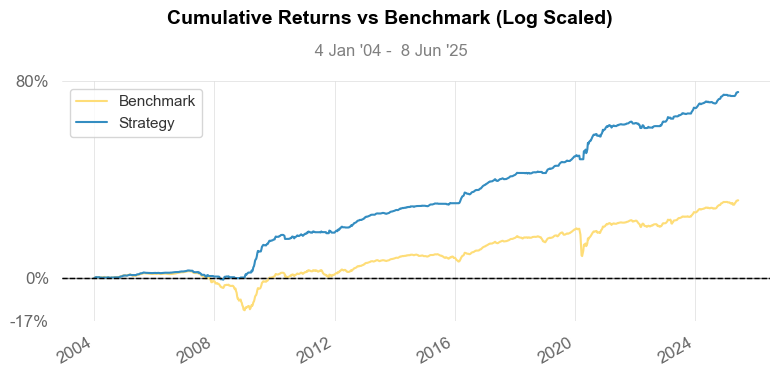

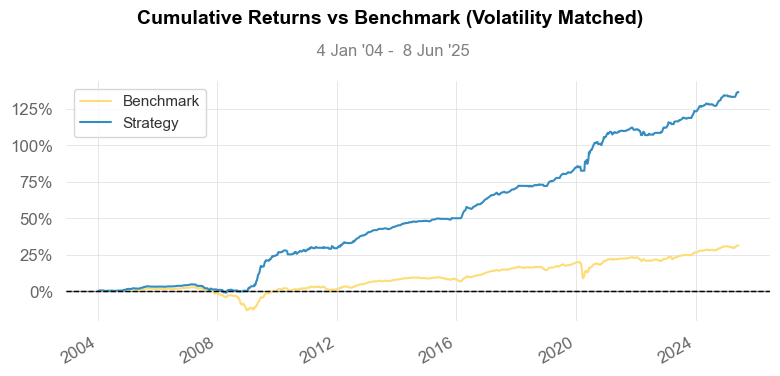

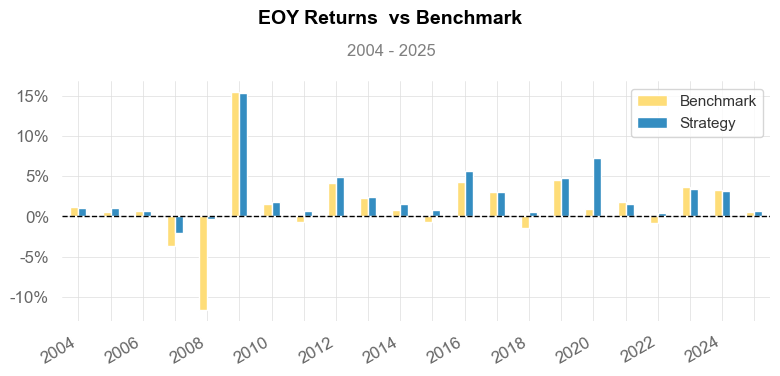

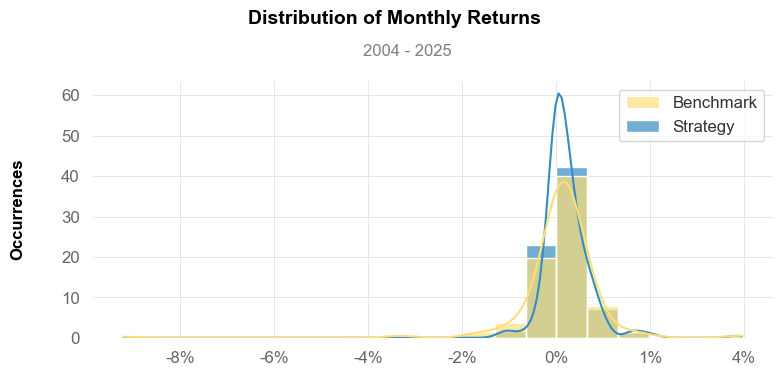

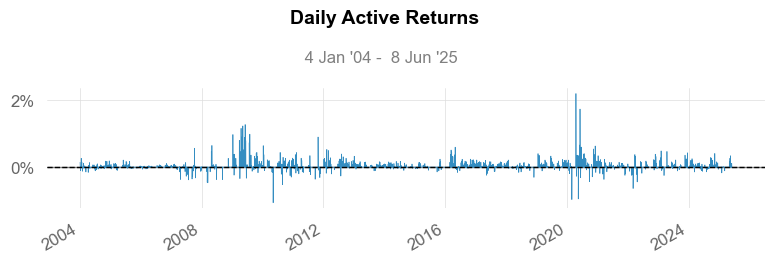

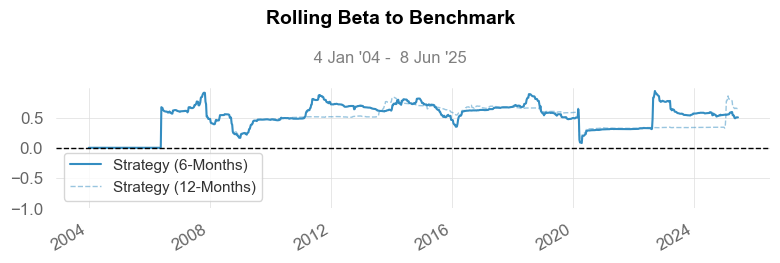

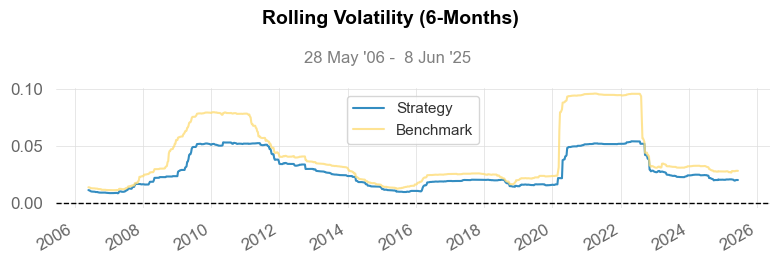

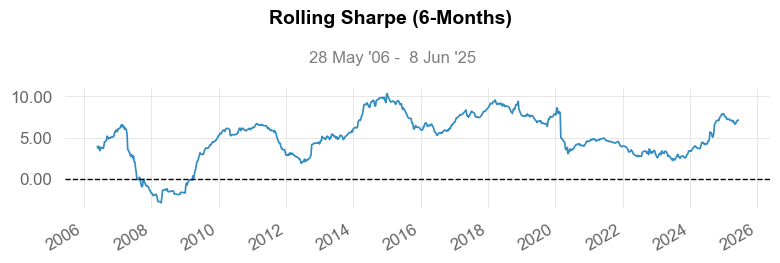

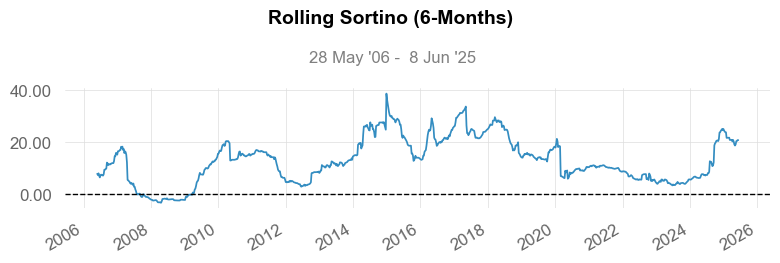

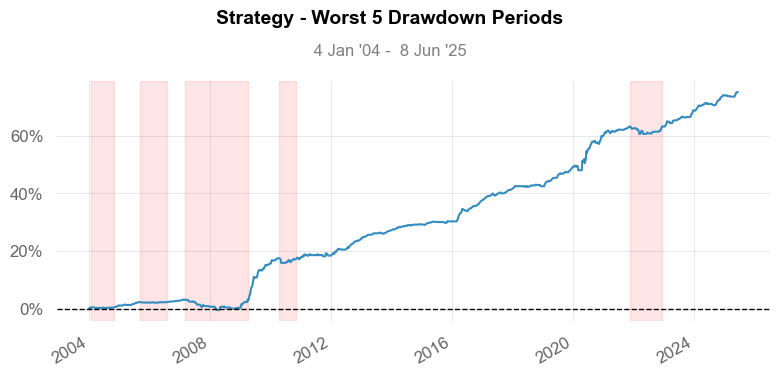

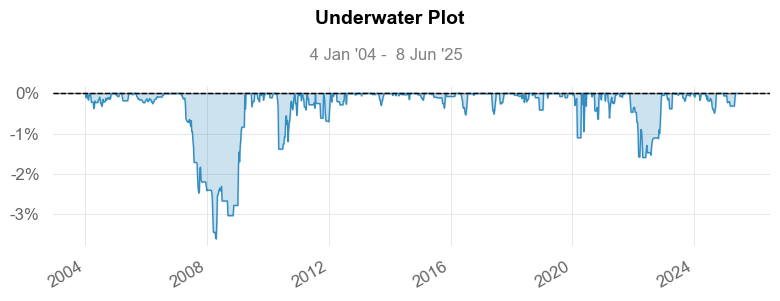

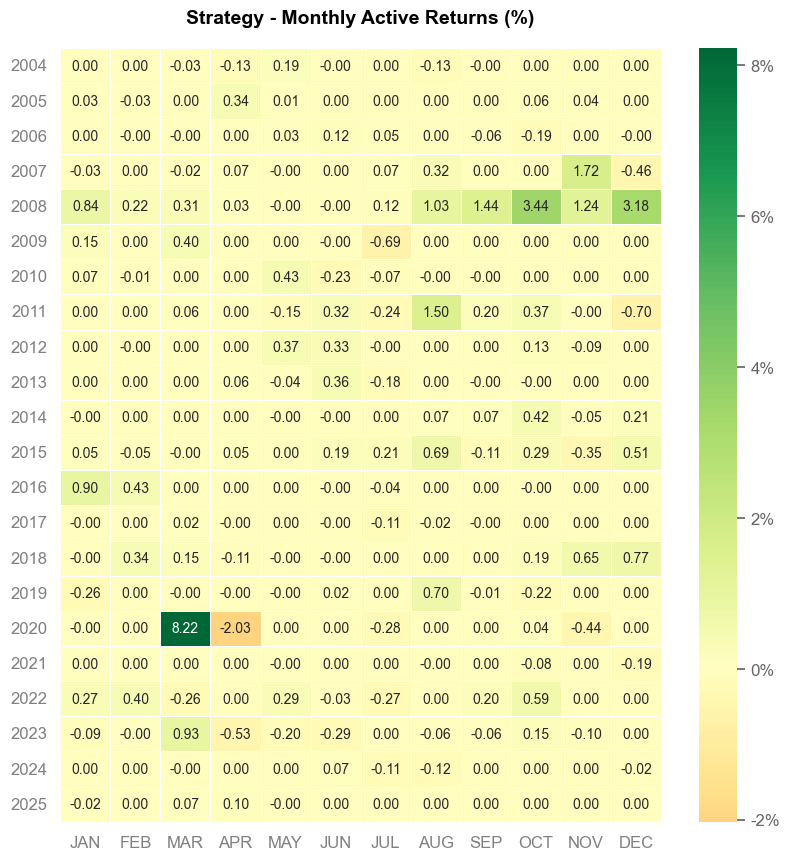

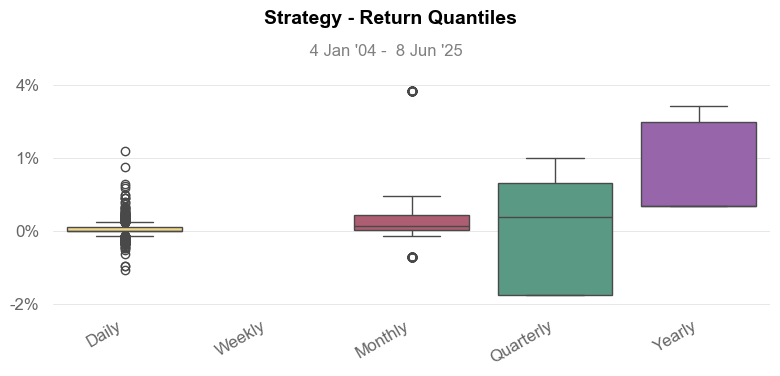

Strategy vs Buy and Hold tearsheet saved to: tearsheets\Multi-asset momentum.html


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectorbt as vbt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# === MULTI-ASSET MOMENTUM STRATEGY WITH VECTORBT ===

# Set threshold parameter
threshold = -0.005

# Load and prepare data
df = pd.read_csv(r"c:\Users\Eddy\YTM Capital Dropbox\Eddy Winiarz\Trading\COF\Models\Unfinished Models\Eddy\Python Projects\BT\data_pipelines\data_processed\with_er_daily.csv", 
             parse_dates=["Date"]).set_index("Date")

# Resample to weekly frequency
weekly_df = df.resample('W').last()

print(f"Strategy Period: {weekly_df.index[0]} to {weekly_df.index[-1]}")
print(f"Total weeks: {len(weekly_df)}")

# Calculate 4-week momentum for each asset
tsx_momentum = weekly_df['tsx'] / weekly_df['tsx'].shift(4) - 1
us_hy_momentum = weekly_df['us_hy_er_index'] / weekly_df['us_hy_er_index'].shift(4) - 1
cad_momentum = weekly_df['cad_ig_er_index'] / weekly_df['cad_ig_er_index'].shift(4) - 1

# Combined momentum signal (average of the three)
combined_momentum = (tsx_momentum + us_hy_momentum + cad_momentum) / 3

# Create entry and exit signals using vectorbt
# Entry signal: combined momentum > threshold
entry_signal = combined_momentum > threshold

# Exit signal: exit after 1 week (we'll shift the entry signal)
# This means we'll exit at the next evaluation point
exit_signal = entry_signal.shift(1).fillna(False)

# Get the price series we're trading (cad_ig_er_index)
price = weekly_df['cad_ig_er_index']

# Create a portfolio using vectorbt
pf = vbt.Portfolio.from_signals(
    price,
    entries=entry_signal,
    exits=exit_signal,
    freq='W',  # Weekly frequency
    init_cash=100,  # Starting with $100
    fees=0.0,  # No fees
    slippage=0.0  # No slippage
)


import os
import quantstats as qs
import numpy as np

# Ensure the output directory exists
output_dir = 'tearsheets'
os.makedirs(output_dir, exist_ok=True)
output_path_bh = os.path.join(output_dir, 'Multi-asset momentum.html')

# For the Buy and Hold tearsheet, you'll use portfolio.returns() as your strategy 
# and buyhold_returns as the benchmark
strategy_returns = pf.returns()

# Fix: Only use cad_ig_er_index for benchmark returns
benchmark_returns = weekly_df['cad_ig_er_index'].pct_change().reindex(strategy_returns.index).fillna(0)
benchmark_returns = benchmark_returns.replace([np.inf, -np.inf], np.nan).dropna()

# Generate the full tearsheet with benchmark comparison
qs.reports.full(
    strategy_returns,
    benchmark=benchmark_returns,  # This adds benchmark comparison
    title='Multi-asset momentum vs Buy and Hold',
    freq='W'
)

# Save the HTML report with benchmark comparison
qs.reports.html(
    strategy_returns,
    benchmark=benchmark_returns,  # This adds benchmark comparison
    output=output_path_bh,
    title='Multi-asset momentum vs Buy and Hold',
    freq='W'
)

print(f"Strategy vs Buy and Hold tearsheet saved to: {output_path_bh}")

# Expert Analysis: Multi-Asset Momentum Strategy

## Potential Statistical Integrity Concerns

### 1. Look-Ahead Bias Risk
- Your combined momentum signal uses the current period's data to make decisions for that same period
- Ensure entry signals at time t only use data available at time t-1
- Verify signal generation doesn't peek into future data

### 2. Overfitting Risk
- Threshold parameter (-0.005) appears hard-coded
- Without proper walk-forward or cross-validation, this value may be optimized for the specific dataset
- Could lead to poor out-of-sample performance

### 3. Transaction Costs
- Current implementation sets fees=0.0, which is unrealistic
- Even low-cost implementations face some transaction costs
- Weekly rebalancing would compound these costs

### 4. Execution Slippage
- slippage=0.0 assumes perfect execution at weekly close prices
- Unrealistic in real trading scenarios
- Should be modeled based on asset liquidity

### 5. Weekly Rebalancing Frequency
- Weekly position evaluation might lead to higher turnover
- Consider if transaction costs justify this frequency
- Test less frequent rebalancing for comparison

### 6. Data Quality
- Weekly resampled data might smooth over market volatility
- Examine if critical information is lost in the resampling process
- Consider sensitivity to resampling method (last vs. mean vs. median)

### 7. Regime Dependency
- Multi-asset momentum strategies perform differently across market regimes
- No regime analysis in current implementation
- Consider testing performance in different market conditions

## Recommended Statistical Robustness Improvements

### 1. Out-of-Sample Testing
- Split dataset into training/testing periods
- Validate performance out-of-sample
- Consider time-series cross-validation approaches

### 2. Parameter Sensitivity Analysis
- Test sensitivity to small changes in threshold parameter (-0.005)
- Create surface plots of performance metrics across parameter ranges
- Identify regions of parameter stability

### 3. Monte Carlo Simulation
- Implement bootstrap resampling
- Generate statistical confidence intervals for performance metrics
- Assess probability distribution of returns and drawdowns

### 4. Realistic Costs
- Implement realistic transaction costs and slippage models
- Include market impact for larger positions
- Adjust historical performance estimates accordingly

### 5. Drawdown Analysis
- Perform detailed analysis of drawdown periods
- Examine recovery times and drawdown clustering
- Identify market conditions associated with poor performance

### 6. Return Distribution Analysis
- Examine skewness, kurtosis, and normality of returns
- Test for autocorrelation in returns
- Assess impact of outliers on performance metrics

### 7. Trade Statistics
- Add metrics like average win/loss, profit factor
- Calculate maximum consecutive losses
- Measure average holding period and turnover ratio